In [14]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
file_name = "./data/train/singlecoil_train/file1000001.h5"
hf = h5py.File(file_name)

In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': np.float64(0.000851878253624366), 'norm': np.float64(0.0596983310320022), 'patient_id': '0beb8905d9b7fad304389b9d4263c57d5b069257ea0fdc5bf7f2675608a47406'}


In [5]:
k_space = hf["kspace"]
print(k_space.shape)
print(k_space.dtype)

(36, 640, 372)
complex64


In [26]:
slice_kspace = k_space[3] # Choosing the 20-th slice of this volume
print(slice_kspace.shape)

(640, 372)


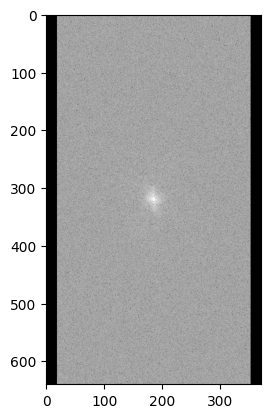

In [27]:
plt.imshow(np.log(np.abs(slice_kspace)+1e-9), cmap='gray')

In [28]:
import fastmri
from fastmri.data import transforms as T

In [29]:
slice_kspace2 = T.to_tensor(slice_kspace) 
slice_image = fastmri.ifft2c(slice_kspace2)          
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

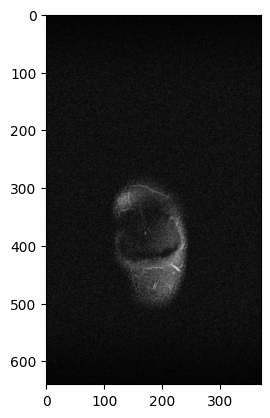

In [30]:
plt.imshow(slice_image_abs, cmap="gray")

In [44]:
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc

class FastMRIDataset(Dataset):
    def __init__(self, file_list, mask_func=None, mode='train', challenge='singlecoil'):
        self.file_list = file_list
        self.mask_func = mask_func
        self.mode = mode
        self.challenge = challenge
        self.examples = []
        
        # Precompute list of slices across all files
        for fpath in file_list:
            with h5py.File(fpath, 'r') as hf:
                kspace = hf['kspace']
                middle_slice = kspace.shape[0] // 2
                self.examples.append((fpath, middle_slice))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        fpath, slice_idx = self.examples[idx]
        
        with h5py.File(fpath, 'r') as hf:
            kspace = hf['kspace'][slice_idx]
            target = hf['reconstruction_rss'][slice_idx] if 'reconstruction_rss' in hf else None
            
            # Convert to tensor and normalize
            kspace_tensor = T.to_tensor(kspace)
            max_value = hf.attrs['max'] if 'max' in hf.attrs else 0.00085
            
            # Apply undersampling mask
            if self.mask_func:
                masked_kspace, mask, _ = T.apply_mask(kspace_tensor, self.mask_func)
            else:
                masked_kspace = kspace_tensor
                
            # Inverse Fourier to get complex image
            image = fastmri.ifft2c(masked_kspace)
            
            # Compute absolute value and normalize
            image_abs = fastmri.complex_abs(image)
            image_abs = image_abs / max_value
            
            # Convert target to tensor and normalize
            target = T.to_tensor(target) / max_value  # Convert numpy array to tensor
            
            # Apply center crop to both input and target (320x320)
            crop_shape = (320, 320)
            image_abs = T.center_crop(image_abs, crop_shape)
            target = T.center_crop(target, crop_shape)
            
            return image_abs, target

# Example usage
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
train_dataset = FastMRIDataset(
    file_list=["./data/train/singlecoil_train/file1000001.h5"],
    mask_func=mask_func,
    mode='train'
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

# Sample batch
for inputs, targets in train_loader:
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    break


Input shape: torch.Size([1, 320, 320]), Target shape: torch.Size([1, 320, 320])


In [45]:
import os
import glob
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc

# Find all h5 files in the training directory
train_dir = "./data/train/singlecoil_train"
h5_files = glob.glob(os.path.join(train_dir, "*.h5"))

# If no files found in the expected location, try alternative paths
if not h5_files:
    # Try alternative directory structure
    alternative_paths = [
        "./data/knee_singlecoil_train/*.h5",
        "./knee_singlecoil_train/*.h5"
    ]
    
    for path in alternative_paths:
        h5_files = glob.glob(path)
        if h5_files:
            print(f"Found {len(h5_files)} files in {path}")
            break
            
    # If still no files, do a recursive search
    if not h5_files:
        print("Searching recursively for h5 files...")
        h5_files = glob.glob("./data/**/*.h5", recursive=True)

print(f"Found {len(h5_files)} h5 files for training")
if h5_files:
    print(f"First file: {h5_files[0]}")

# Example usage
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
train_dataset = FastMRIDataset(
    file_list=h5_files,
    mask_func=mask_func,
    mode='train'
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

# Sample batch
for inputs, targets in train_loader:
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    break

Found 973 h5 files for training
First file: ./data/train/singlecoil_train/file1002073.h5
Input shape: torch.Size([16, 320, 320]), Target shape: torch.Size([16, 320, 320])


Input shape: torch.Size([16, 320, 320]), Target shape: torch.Size([16, 320, 320])


TypeError: Invalid shape (320,) for image data

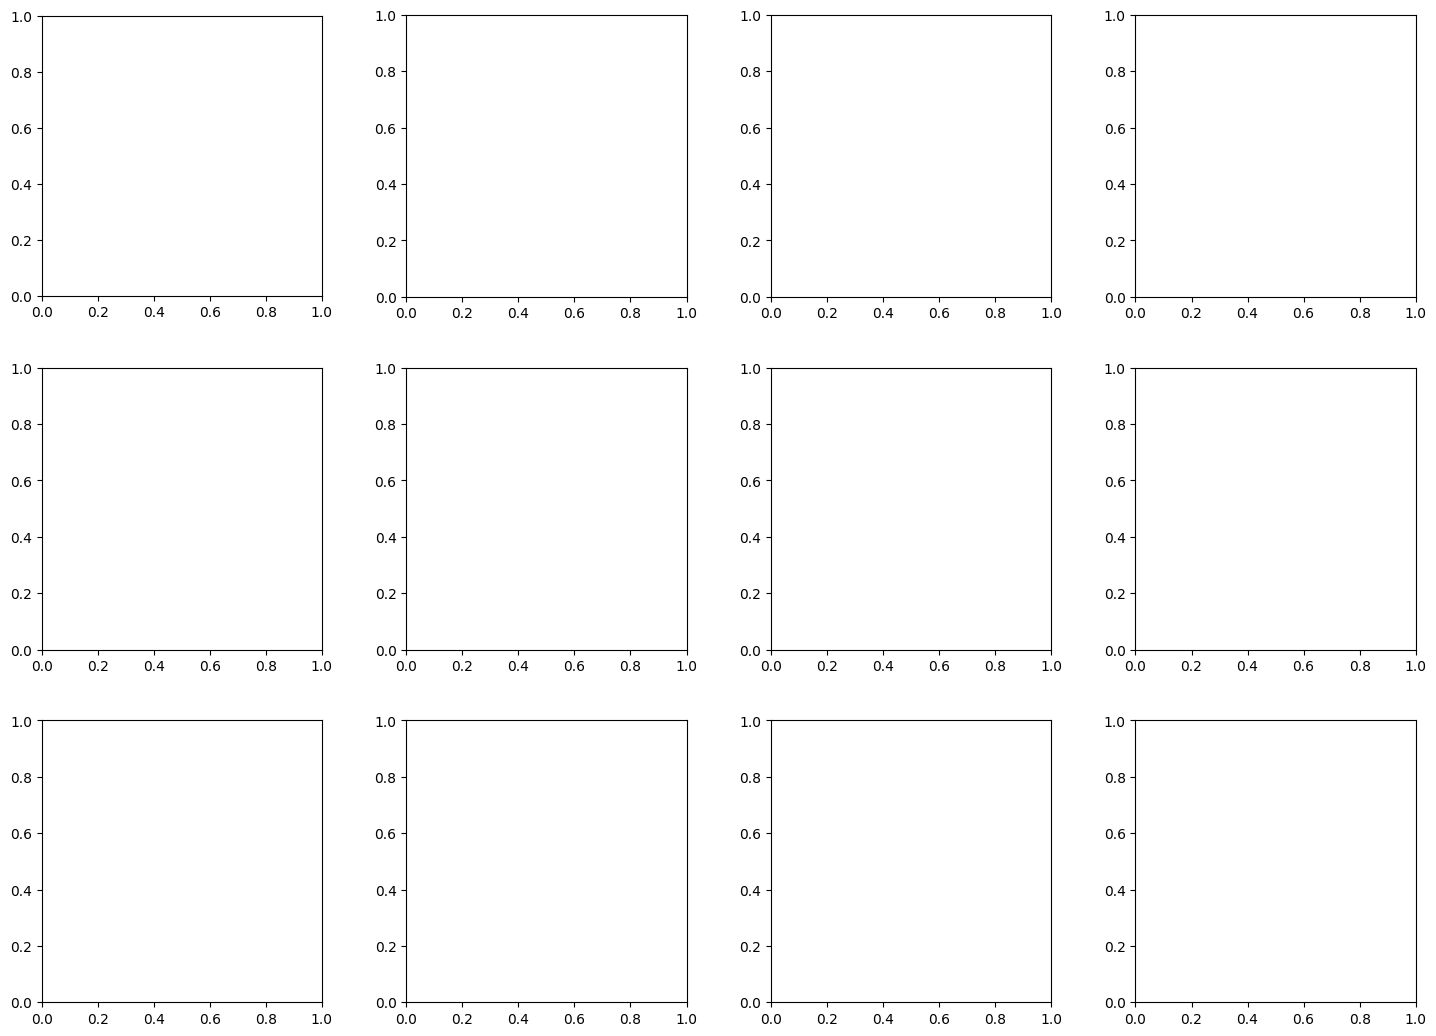

In [46]:
import matplotlib.pyplot as plt

# Get a batch from the train_loader
for inputs, targets in train_loader:
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    break

# Plot a few examples
fig, axes = plt.subplots(3, 4, figsize=(15, 11))
plt.tight_layout(pad=3.0)

# Display 6 examples (3 rows, each with input + target)
for i in range(3):
    for j in range(2):
        idx = i*2 + j
        
        # Show input image
        ax = axes[i, j*2]
        im = ax.imshow(inputs[idx, 0].cpu().numpy(), cmap='gray')
        ax.set_title(f"Input {idx+1}")
        ax.axis('off')
        
        # Show target image
        ax = axes[i, j*2+1]
        im = ax.imshow(targets[idx, 0].cpu().numpy(), cmap='gray')
        ax.set_title(f"Target {idx+1}")
        ax.axis('off')

plt.suptitle("FastMRI Dataset Samples", fontsize=16)
plt.show()

Input shape: torch.Size([16, 1, 320, 320]), Target shape: torch.Size([16, 1, 320, 320])


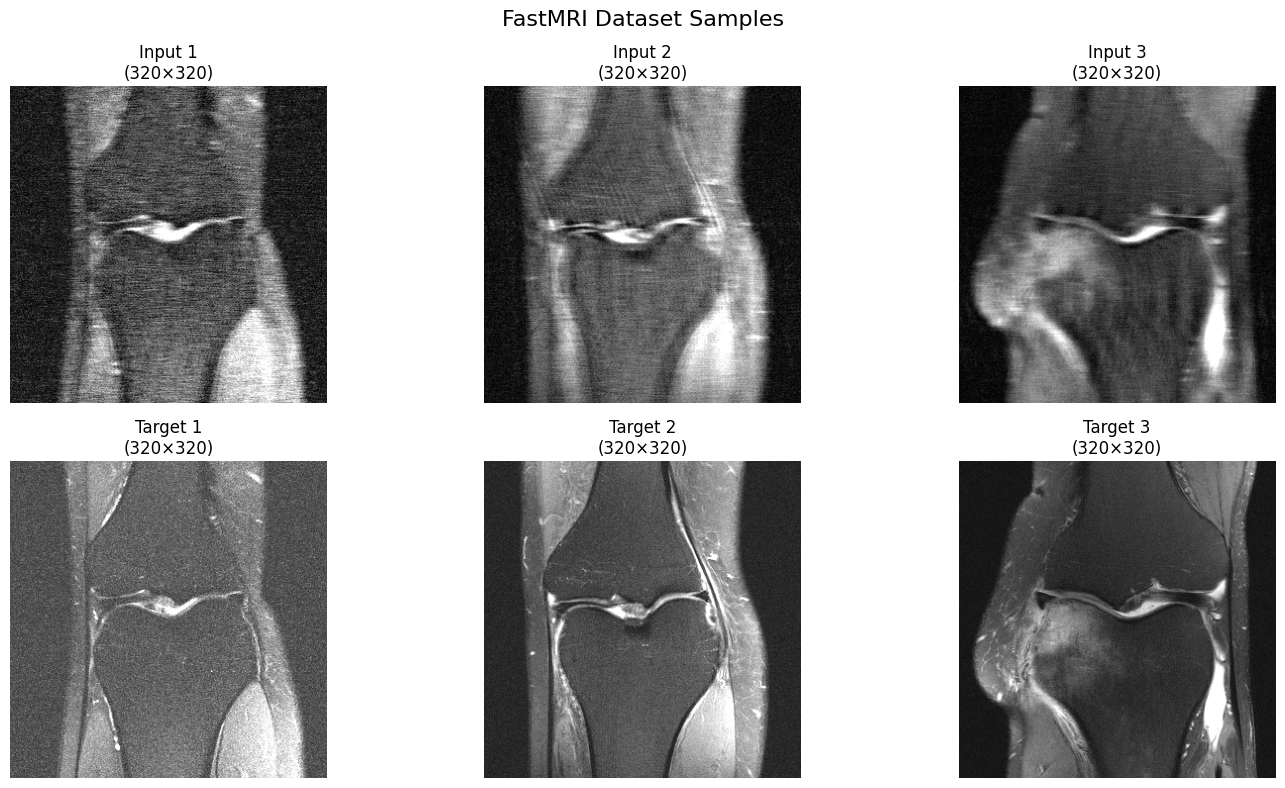

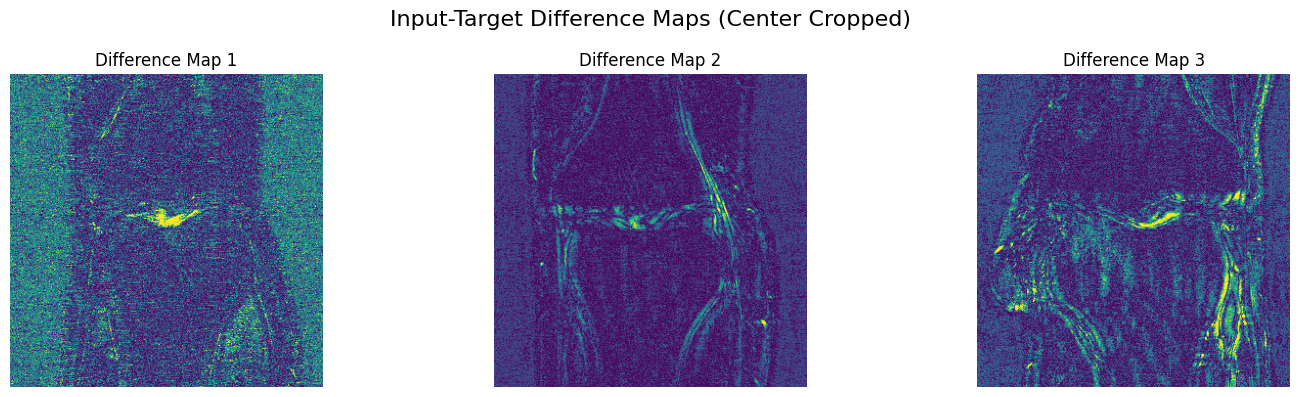

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from the train_loader
batch_inputs, batch_targets = next(iter(train_loader))
print(f"Input shape: {batch_inputs.shape}, Target shape: {batch_targets.shape}")

# Create a figure with two rows - top for inputs, bottom for targets
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Display 3 examples in each row
for i in range(3):
    # Show input image with proper normalization
    input_img = batch_inputs[i, 0].cpu().numpy()
    ax = axes[0, i]
    im = ax.imshow(input_img, cmap='gray', vmin=0, vmax=np.percentile(input_img, 99))
    ax.set_title(f"Input {i+1}\n({batch_inputs.shape[2]}×{batch_inputs.shape[3]})")
    ax.axis('off')
    
    # Show target image with proper normalization
    target_img = batch_targets[i, 0].cpu().numpy()
    ax = axes[1, i]
    im = ax.imshow(target_img, cmap='gray', vmin=0, vmax=np.percentile(target_img, 99))
    ax.set_title(f"Target {i+1}\n({batch_targets.shape[2]}×{batch_targets.shape[3]})")
    ax.axis('off')

plt.suptitle("FastMRI Dataset Samples", fontsize=16)
plt.tight_layout()
plt.show()

# Display difference maps to highlight reconstruction artifacts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    # Center crop the input to match target size for comparison
    h_diff = (batch_inputs.shape[2] - batch_targets.shape[2]) // 2
    w_diff = (batch_inputs.shape[3] - batch_targets.shape[3]) // 2
    
    cropped_input = batch_inputs[i, 0, 
                                h_diff:h_diff+batch_targets.shape[2], 
                                w_diff:w_diff+batch_targets.shape[3]].cpu().numpy()
    
    target = batch_targets[i, 0].cpu().numpy()
    
    # Show difference map (highlights reconstruction errors)
    diff = np.abs(cropped_input - target)
    axes[i].imshow(diff, cmap='viridis', vmax=diff.max()*0.5)
    axes[i].set_title(f"Difference Map {i+1}")
    axes[i].axis('off')

plt.suptitle("Input-Target Difference Maps (Center Cropped)", fontsize=16)
plt.tight_layout()
plt.show()

In [47]:
import os
import torch
import glob
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

def save_processed_dataset(dataset, output_dir, batch_size=16, prefix="fastmri"):
    """Save processed FastMRI dataset to disk for later use
    
    Args:
        dataset: Your FastMRIDataset instance
        output_dir: Directory to save processed data
        batch_size: How many samples to save in each file
        prefix: Filename prefix for saved files
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a dataloader to process in batches
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    print(f"Processing and saving {len(dataset)} samples to {output_dir}...")
    
    for i, (inputs, targets) in enumerate(tqdm(loader)):
        # Save each batch as a separate file
        batch_file = os.path.join(output_dir, f"{prefix}_batch_{i:04d}.pt")
        torch.save({
            'inputs': inputs,
            'targets': targets
        }, batch_file)
    
    # Save metadata
    metadata = {
        'num_samples': len(dataset),
        'num_batches': len(loader),
        'batch_size': batch_size,
        'shape': (inputs.shape[1:], targets.shape[1:])  # Save the tensor shapes without batch dimension
    }
    torch.save(metadata, os.path.join(output_dir, f"{prefix}_metadata.pt"))
    print(f"Saved {len(dataset)} samples in {len(loader)} batch files")

class ProcessedFastMRIDataset(Dataset):
    """Dataset for loading preprocessed FastMRI data"""
    
    def __init__(self, data_dir, prefix="fastmri"):
        """
        Args:
            data_dir: Directory containing saved processed data
            prefix: Filename prefix used when saving
        """
        self.data_dir = data_dir
        self.prefix = prefix
        
        # Load metadata
        metadata_file = os.path.join(data_dir, f"{prefix}_metadata.pt")
        if not os.path.exists(metadata_file):
            raise FileNotFoundError(f"Metadata file not found at {metadata_file}")
        
        self.metadata = torch.load(metadata_file)
        self.num_samples = self.metadata['num_samples']
        self.batch_size = self.metadata['batch_size']
        
        # Get all batch files
        self.batch_files = sorted(glob.glob(os.path.join(data_dir, f"{prefix}_batch_*.pt")))
        if not self.batch_files:
            raise FileNotFoundError(f"No batch files found in {data_dir}")
        
        # Create index mapping to quickly locate samples
        self.sample_map = {}
        for i in range(self.num_samples):
            batch_idx = i // self.batch_size
            sample_idx = i % self.batch_size
            self.sample_map[i] = (batch_idx, sample_idx)
        
        # Cache for loaded batches to avoid reloading same file
        self.cache = {'batch_idx': -1, 'data': None}
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        batch_idx, sample_idx = self.sample_map[idx]
        
        # Load batch if not in cache
        if self.cache['batch_idx'] != batch_idx:
            batch_data = torch.load(self.batch_files[batch_idx])
            self.cache = {'batch_idx': batch_idx, 'data': batch_data}
        
        # Return the specific sample from the batch
        inputs = self.cache['data']['inputs'][sample_idx]
        targets = self.cache['data']['targets'][sample_idx]
        
        return inputs, targets


In [50]:
import os
import glob
import torch
from torch.utils.data import DataLoader

# Step 1: Process and save your dataset
# Find all h5 files in your training directory
train_dir = "./data/train/singlecoil_train"
h5_files = glob.glob(os.path.join(train_dir, "*.h5"))

# Create your original dataset
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
train_dataset = FastMRIDataset(
    file_list=h5_files,
    mask_func=mask_func,
    mode='train'
)

# Save processed dataset (only need to do this once)
save_processed_dataset(
    dataset=train_dataset,
    output_dir="./processed_fastmri_data/train",
    batch_size=16,
    prefix="fastmri_train_4x"
)

Processing and saving 973 samples to ./processed_fastmri_data/train...


100%|██████████| 61/61 [00:04<00:00, 13.09it/s]

Saved 973 samples in 61 batch files


In [51]:
import os
import glob
import torch
from torch.utils.data import DataLoader

# Step 1: Process and save your dataset
# Find all h5 files in your training directory
val_dir = "./data/val/singlecoil_val"
h5_files = glob.glob(os.path.join(val_dir, "*.h5"))

# Create your original dataset
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
train_dataset = FastMRIDataset(
    file_list=h5_files,
    mask_func=mask_func,
    mode='train'
)

# Save processed dataset (only need to do this once)
save_processed_dataset(
    dataset=train_dataset,
    output_dir="./processed_fastmri_data/val",
    batch_size=16,
    prefix="fastmri_val_4x"
)

Processing and saving 199 samples to ./processed_fastmri_data/val...


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:01<00:00,  7.83it/s]

Saved 199 samples in 13 batch files
